# Получение frustum примеров из сырых данных

In [1]:
from IPython.display import Image
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [2]:
Image(url='http://www.cvlibs.net/datasets/kitti/images/passat_sensors.jpg')

In [3]:
with open('projection_example.npy') as f:
    data_example = pickle.load(file=f)

In [4]:
xyz = data_example['lidar_xyz']
intensity = data_example['intensity']
car_to_cam = data_example['car_to_cam']
car_to_lidar = data_example['car_to_lidar']
intrinsic = data_example['intrinsics']
image = data_example['image']

(-35, 35)

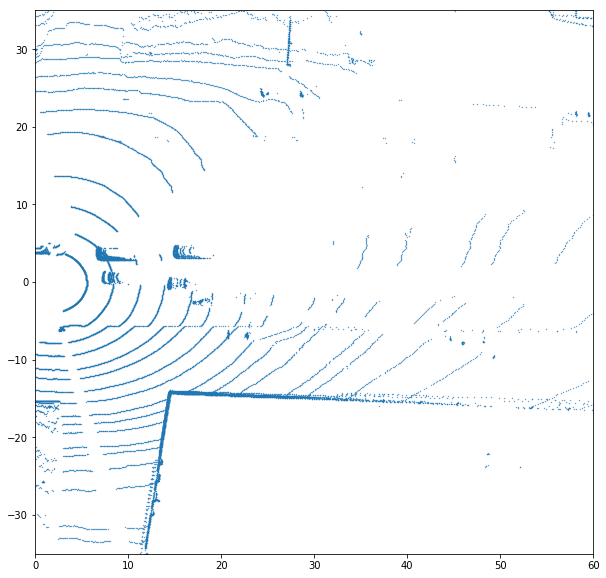

In [5]:
plt.figure(figsize=(10, 10))
plt.scatter(xyz[:, 0], xyz[:, 1], s=0.1)
plt.xlim(0, 60)
plt.ylim(-35, 35)

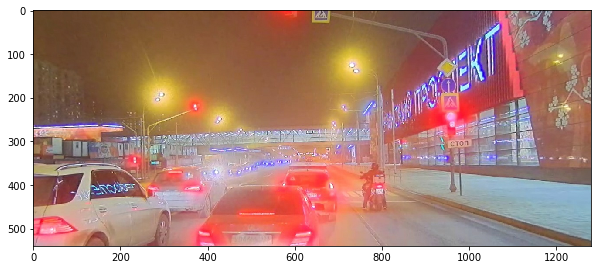

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(image)

In [7]:
bbox = np.array(((350, 750), (460, 810)))

In [8]:
def bbox_to_vertices(bbox):
    return np.array([bbox[0], [bbox[0, 0], bbox[1, 1]], bbox[1], [bbox[1, 0], bbox[0, 1]], bbox[0]])

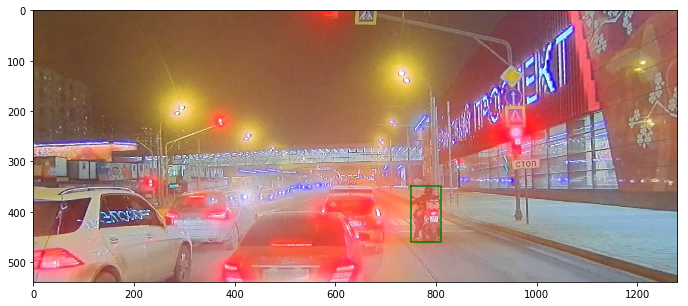

In [9]:
vertices = bbox_to_vertices(bbox)
plt.figure(figsize=(15, 5))
plt.imshow(image)
plt.plot(vertices[:, 1], vertices[:, 0], c='g')

# Что хотим сделать? 

* Спроецируем точки лидара в камеру
* Посмотрим какие точки попали в коробку
* Оставим только эти точки

In [10]:
transform = intrinsic.dot(car_to_cam)

In [12]:
transform.shape

(3, 4)

In [13]:
xyz_homogen = np.pad(xyz, ((0, 0), (0, 1)), mode='constant', constant_values=1)

In [15]:
xyz_homogen[0]

array([8.9204306e-04, 3.7683442e+00, 1.3159605e+00, 1.0000000e+00],
      dtype=float32)

In [17]:
xyw = xyz_homogen.dot(transform.T)

In [19]:
xyw[0]

array([-4.7056577e+03, -2.0033447e+01, -1.3436437e+00], dtype=float32)

In [21]:
xy_cam = xyw[:, :2] / xyw[:, 2:]

In [23]:
xy_cam

array([[ 3502.1619  ,    14.909792],
       [ 4036.8774  ,    71.02936 ],
       [ 3534.7668  ,    11.405792],
       ...,
       [-5374.17    ,  -523.9307  ],
       [-5245.3345  ,  -505.70694 ],
       [-5133.566   ,  -490.01288 ]], dtype=float32)

In [24]:
xy_cam_mask = (xy_cam[:, 1] < 540) * (xy_cam[:, 1] > 0) * (xy_cam[:, 0] < 1240) * (xy_cam[:, 0] > 0) * (xyz[:, 0] > 0)

In [27]:
r = np.linalg.norm(xyz[:, :2], axis=1)

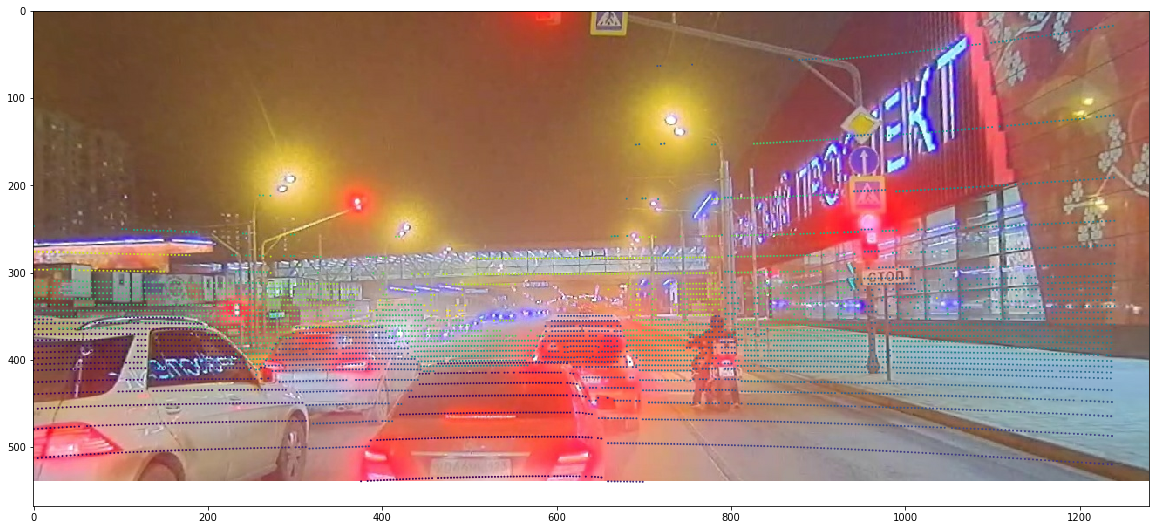

In [28]:
plt.figure(figsize=(20, 10))
plt.imshow(image)
plt.scatter(xy_cam[xy_cam_mask, 0], xy_cam[xy_cam_mask, 1], c=np.log1p(r[xy_cam_mask]), s=1)

In [29]:
xy_cam = xy_cam[xy_cam_mask]

In [30]:
in_box = (xy_cam[:, 1] > bbox[0, 0]) * (xy_cam[:, 1] < bbox[1, 0]) * (xy_cam[:, 0] < bbox[1, 1]) * (xy_cam[:, 0] > bbox[0, 1]) 

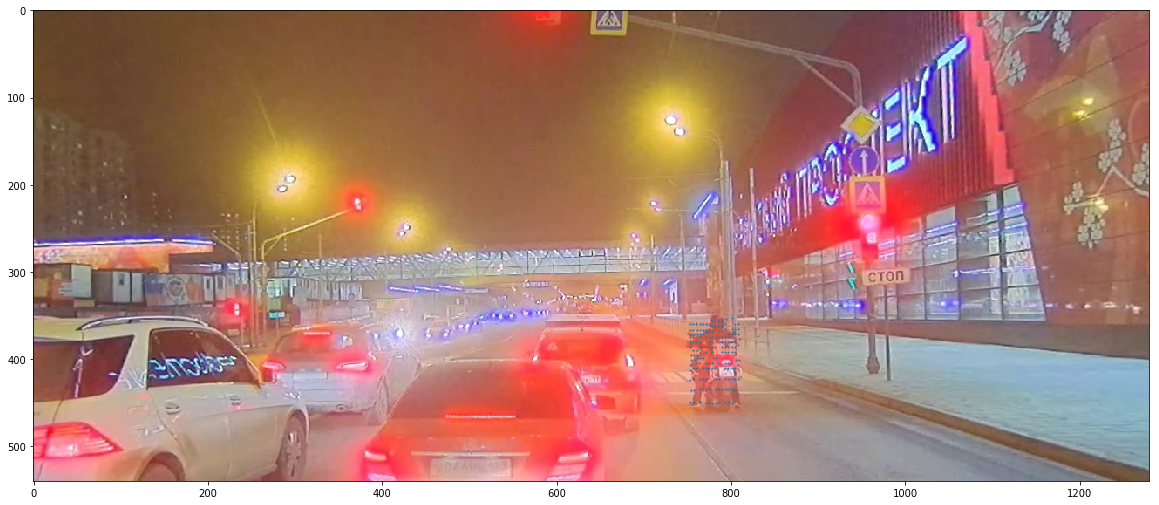

In [31]:
plt.figure(figsize=(20, 10))
plt.imshow(image)
plt.scatter(xy_cam[in_box, 0], xy_cam[in_box, 1], s=1)

In [32]:
xyz_frustum = xyz[xy_cam_mask][in_box]

(-25, 25)

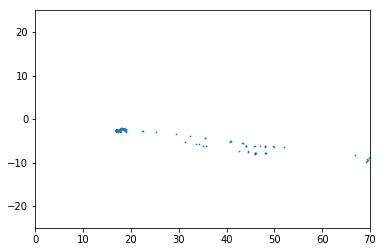

In [33]:
plt.scatter(xyz_frustum[:, 0], xyz_frustum[:, 1], s=0.5)
plt.xlim(0, 70)
plt.ylim(-25, 25)